# EDA - dataset CIDDS-001

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load the dataset

In [2]:
df = pd.read_parquet("../datasets/CIDDS-001/cidds-001-openstack.parquet")

# Creation of a bool column Attack (this will be done in the pipeline, as well as data cleaning and preprocessing)
df.drop(columns=['label'], inplace=True)  # No need to distinguish between attacker and victim
df['attack'] = df['attack_type'].apply(lambda x: False if x == 'benign' else True)

# Drop constant columns (also this will be done in the pipeline)
df.drop(columns=[col for col in df.columns if df[col].nunique() == 1], inplace=True)

# Drop useless columns (also this will be done in the pipeline)
df.drop(columns=['attack_id'], inplace=True)

# Cast eligible float columns to int (also this will be done in the pipeline)
for col in df.select_dtypes(include=['float']).columns:
    # Check if all values in the column are integers
    if np.all(df[col] == df[col].astype(int)):
        df[col] = df[col].astype(int)

# Cast integer columns with min value 0 and max value 1 to bool (also this will be done in the pipeline)
columns_to_cast = [col for col in df.columns
                   if pd.api.types.is_integer_dtype(df[col]) and df[col].min() == 0 and df[col].max() == 1]
df[columns_to_cast] = df[columns_to_cast].astype(bool)

df.head()

,duration,proto,packets,bytes,tcp_ack,tcp_psh,tcp_rst,tcp_syn,tcp_fin,tos,attack_type,attack
0,0.018,TCP,2,338,True,True,False,False,False,0,benign,False
1,0.000,TCP,1,212,True,True,False,False,False,32,benign,False
2,0.000,TCP,1,108,True,True,False,False,False,0,benign,False
3,0.006,TCP,2,174,True,True,False,False,False,0,benign,False
4,0.019,TCP,2,338,True,True,False,False,False,0,benign,False


In [3]:
df.shape

(4161690, 12)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,4161690.0,0.733058,2.072006e+00,0.0,0.127,0.346,0.932,2.380080e+02
packets,4161690.0,101.560599,2.694825e+03,1.0,5.000,8.000,13.000,2.087680e+05
bytes,4161690.0,141632.443953,5.589196e+06,42.0,1093.000,2132.000,5661.000,5.162000e+08
tos,4161690.0,12.973726,1.595379e+01,0.0,0.000,0.000,32.000,1.920000e+02


## Data Cleaning Checks

### Missing Values

In [5]:
df.isnull().sum()

duration       0
proto          0
packets        0
bytes          0
tcp_ack        0
tcp_psh        0
tcp_rst        0
tcp_syn        0
tcp_fin        0
tos            0
attack_type    0
attack         0
dtype: int64

### Duplicate Rows

In [6]:
df[df.duplicated()].head()

,duration,proto,packets,bytes,tcp_ack,tcp_psh,tcp_rst,tcp_syn,tcp_fin,tos,attack_type,attack
2297705,0.000,ICMP,1,42,False,False,False,False,False,0,portScan,True
2328526,0.000,TCP,1,66,True,False,False,False,True,0,portScan,True
2328527,0.003,TCP,2,132,True,False,False,False,True,0,portScan,True
2328533,0.002,TCP,2,132,True,False,False,False,True,0,portScan,True
2367373,0.001,TCP,2,140,True,False,False,True,False,0,dos,True


In [7]:
# Exclude duplicate rows from train_data (also this will be done in the pipeline)
df = df[~df.duplicated()]

In [8]:
df.shape

(4156703, 12)

## EDA

### Univariate Analysis

For each non-numerical column, show the values and plot the distribution

Column proto
------------------------------
Unique Values (4): ['TCP  ', 'UDP  ', 'IGMP ', 'ICMP ']
Categories (4, object): ['ICMP ', 'IGMP ', 'TCP  ', 'UDP  ']

Value Counts:
TCP      4117561
UDP        37220
ICMP        1319
IGMP         603
Name: proto, dtype: int64



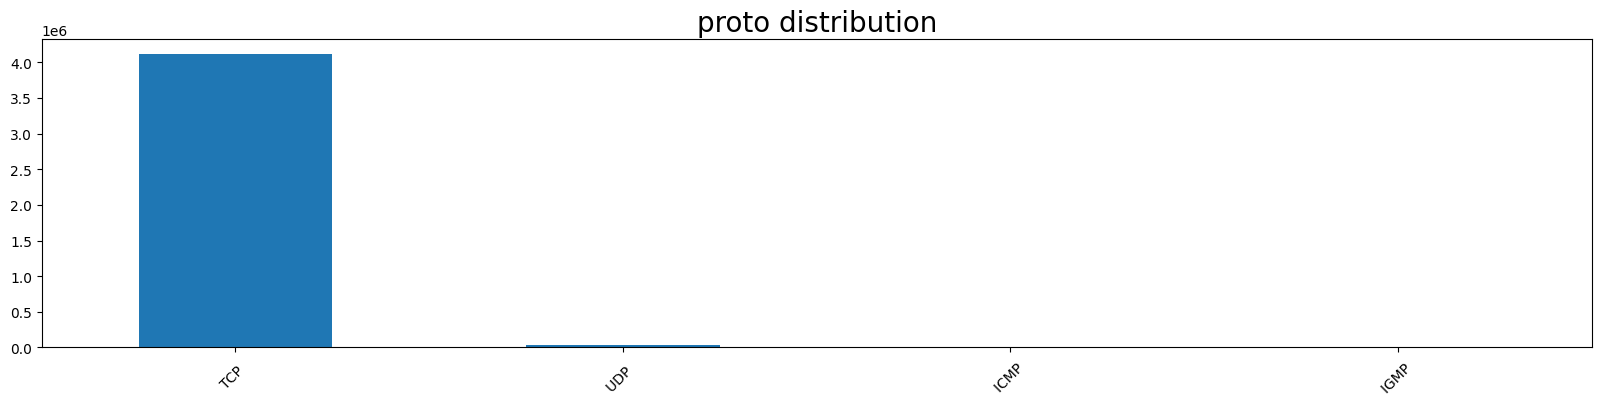

Column tcp_ack
------------------------------
Unique Values (2): [ True False]

Value Counts:
True     4114809
False      41894
Name: tcp_ack, dtype: int64



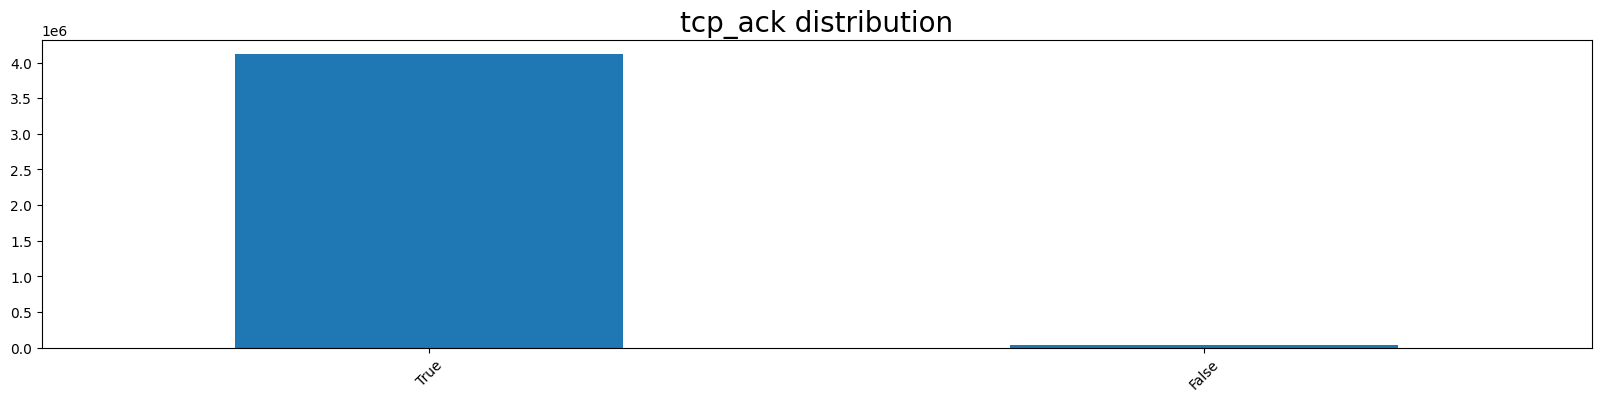

Column tcp_psh
------------------------------
Unique Values (2): [ True False]

Value Counts:
True     4044537
False     112166
Name: tcp_psh, dtype: int64



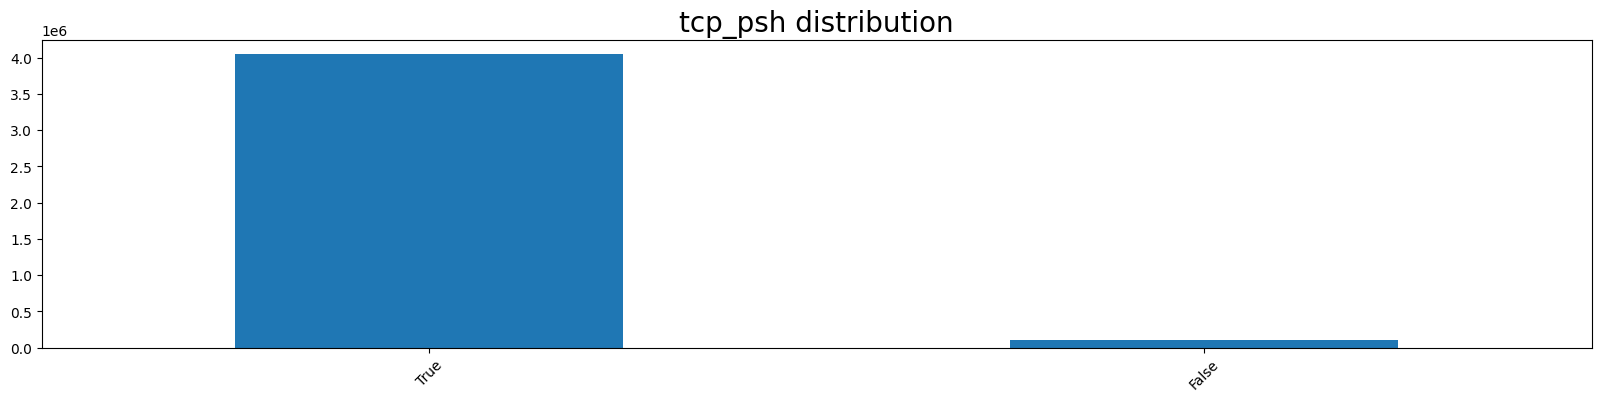

Column tcp_rst
------------------------------
Unique Values (2): [False  True]

Value Counts:
False    4094679
True       62024
Name: tcp_rst, dtype: int64



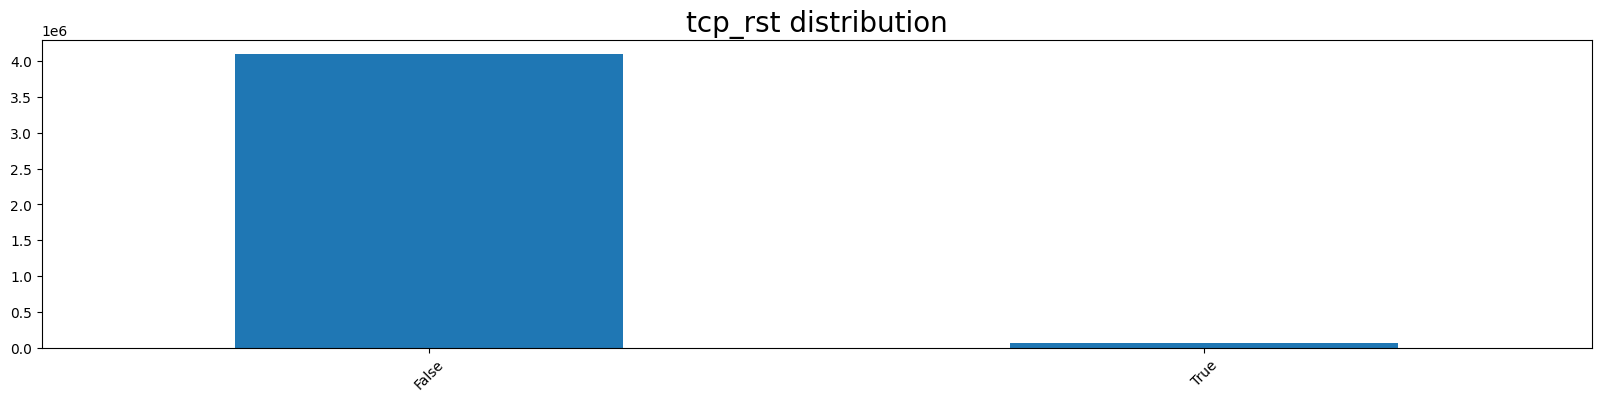

Column tcp_syn
------------------------------
Unique Values (2): [False  True]

Value Counts:
True     2600218
False    1556485
Name: tcp_syn, dtype: int64



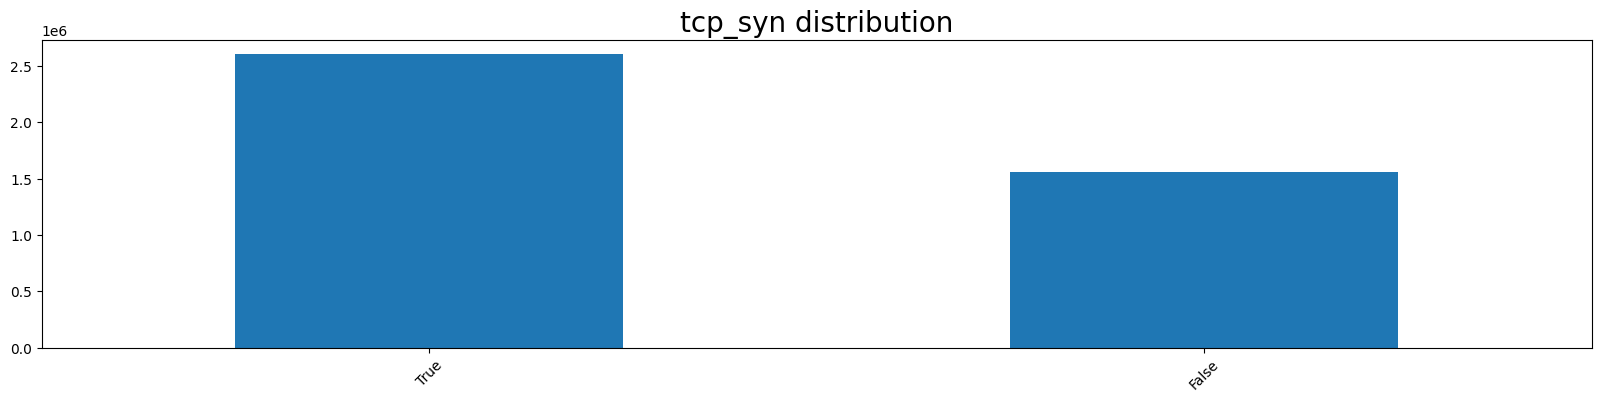

Column tcp_fin
------------------------------
Unique Values (2): [False  True]

Value Counts:
False    3498038
True      658665
Name: tcp_fin, dtype: int64



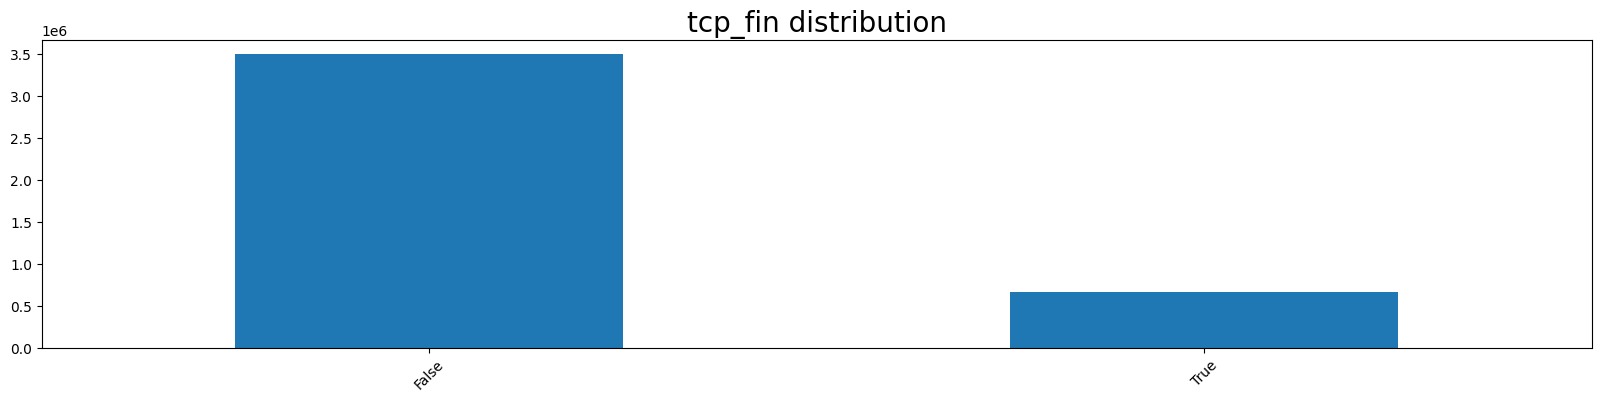

Column attack_type
------------------------------
Unique Values (5): ['benign', 'portScan', 'dos', 'pingScan', 'bruteForce']
Categories (5, object): ['benign', 'bruteForce', 'dos', 'pingScan', 'portScan']

Value Counts:
benign        4152916
dos              1870
portScan          944
bruteForce        516
pingScan          457
Name: attack_type, dtype: int64



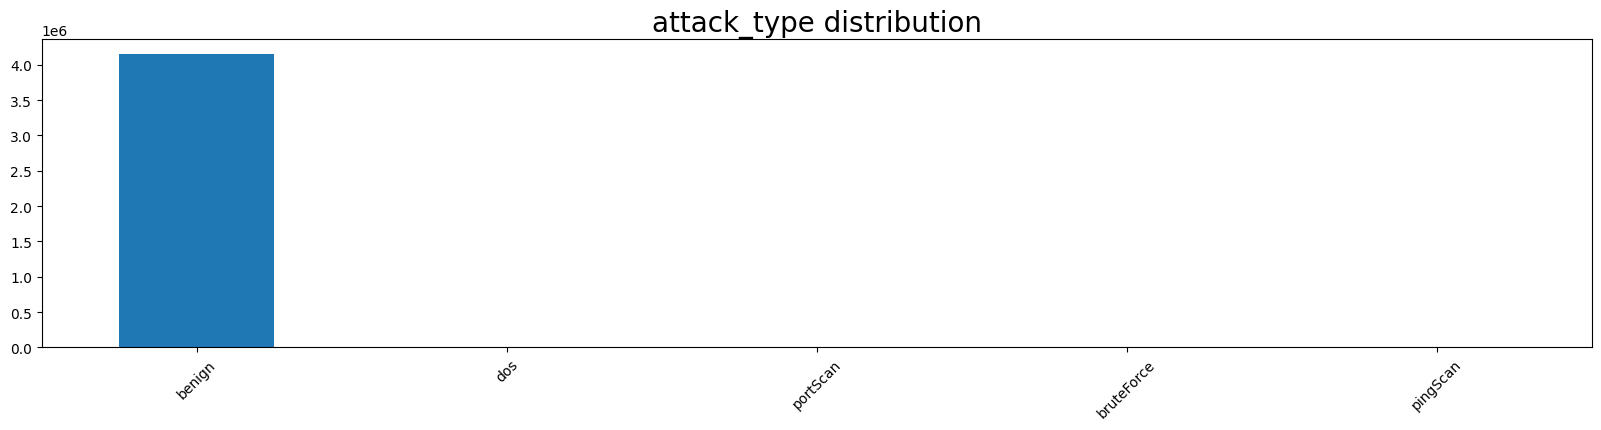

Column attack
------------------------------
Unique Values (2): [False  True]

Value Counts:
False    4152916
True        3787
Name: attack, dtype: int64



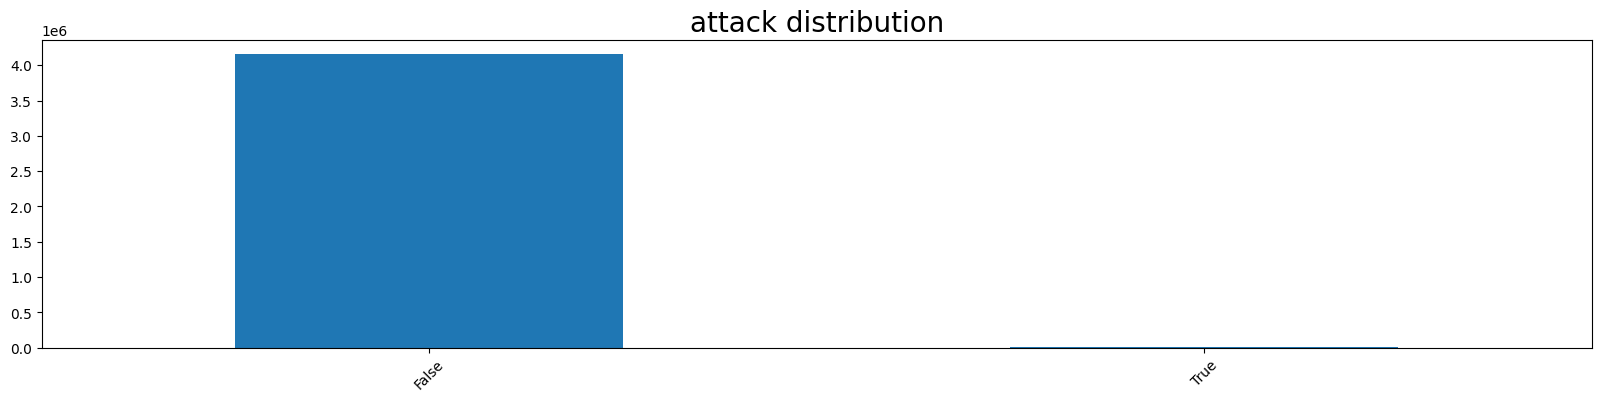

In [9]:
# Non-numerical columns
non_numerical_columns = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Show the distribution for each one
for column_name in non_numerical_columns:
    print(f"Column {column_name}\n{'-'*30}")
    unique_vals = df[column_name].unique()
    value_counts = df[column_name].value_counts()
    print(f"Unique Values ({len(unique_vals)}): {unique_vals}\n")
    print(f"Value Counts:\n{value_counts}\n{'='*40}\n")
    plt.figure(figsize=(20,4))
    value_counts.plot(kind="bar")
    plt.title(f"{column_name} distribution", fontsize=20)
    plt.xticks(rotation=45)
    plt.show()

Violin plot for each numerical feature

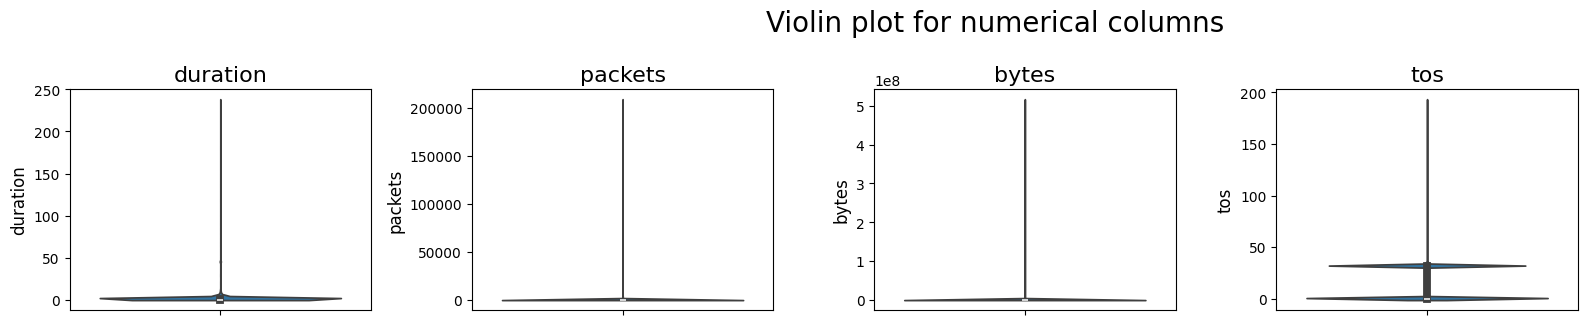

In [10]:
# Numerical columns
numerical_columns = df.select_dtypes(exclude=['object', 'category', 'bool']).columns.tolist()

# Create subplots for violin plots
fig, axes = plt.subplots(16, 5, figsize=(20, 40))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Generate a violin plot for each numerical column
for i, col in enumerate(numerical_columns):
    sns.violinplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(col, fontsize=16)
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col, fontsize=12)

# Remove any extra subplots
for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Violin plot for numerical columns', fontsize=20)
plt.subplots_adjust(top=0.96)
plt.show()

Semi-log histogram for each numerical feature

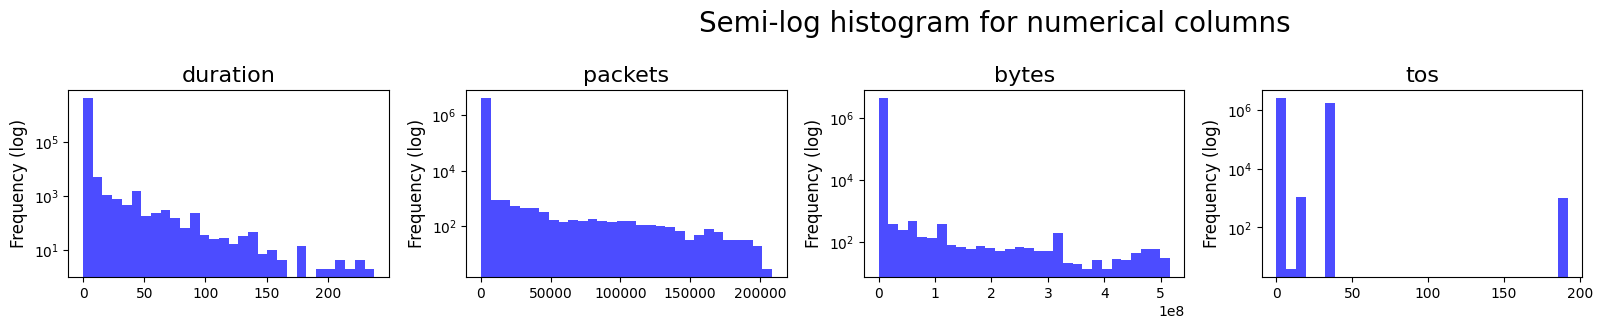

In [11]:
# Create subplots for semi-log histograms
fig, axes = plt.subplots(16, 5, figsize=(20, 40))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Generate a semi-log histogram for each numerical column
for i, col in enumerate(numerical_columns):
    axes[i].hist(df[col], bins=30, log=True, color='blue', alpha=0.7)
    axes[i].set_title(col, fontsize=16)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency (log)', fontsize=12)

# Remove any extra subplots
for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Semi-log histogram for numerical columns', fontsize=20)
plt.subplots_adjust(top=0.96)
plt.show()

Plot the distributions of Attack and Attack Types with percentages

In [12]:
def plot_distribution_with_percentages(col_name):
    plt.figure(figsize=(20, 8))
    ax = sns.countplot(data=df, x=col_name, hue=col_name, legend=False)
    total = len(df)
    for p in ax.patches:
        count = int(p.get_height())
        percentage = 100 * count / total
        if percentage > 0:
            ax.annotate(f'{count} ({percentage:.1f}%)', (p.get_x() + p.get_width() / 2., p.get_height() * 0.985), 
                    ha='center', va='baseline', fontsize=8, color='black', xytext=(0, 5), 
                    textcoords='offset points')

    plt.title(f"Distribution of {col_name} with percentages", fontsize=20)
    plt.xlabel(col_name)
    plt.ylabel("Count")
    plt.show()

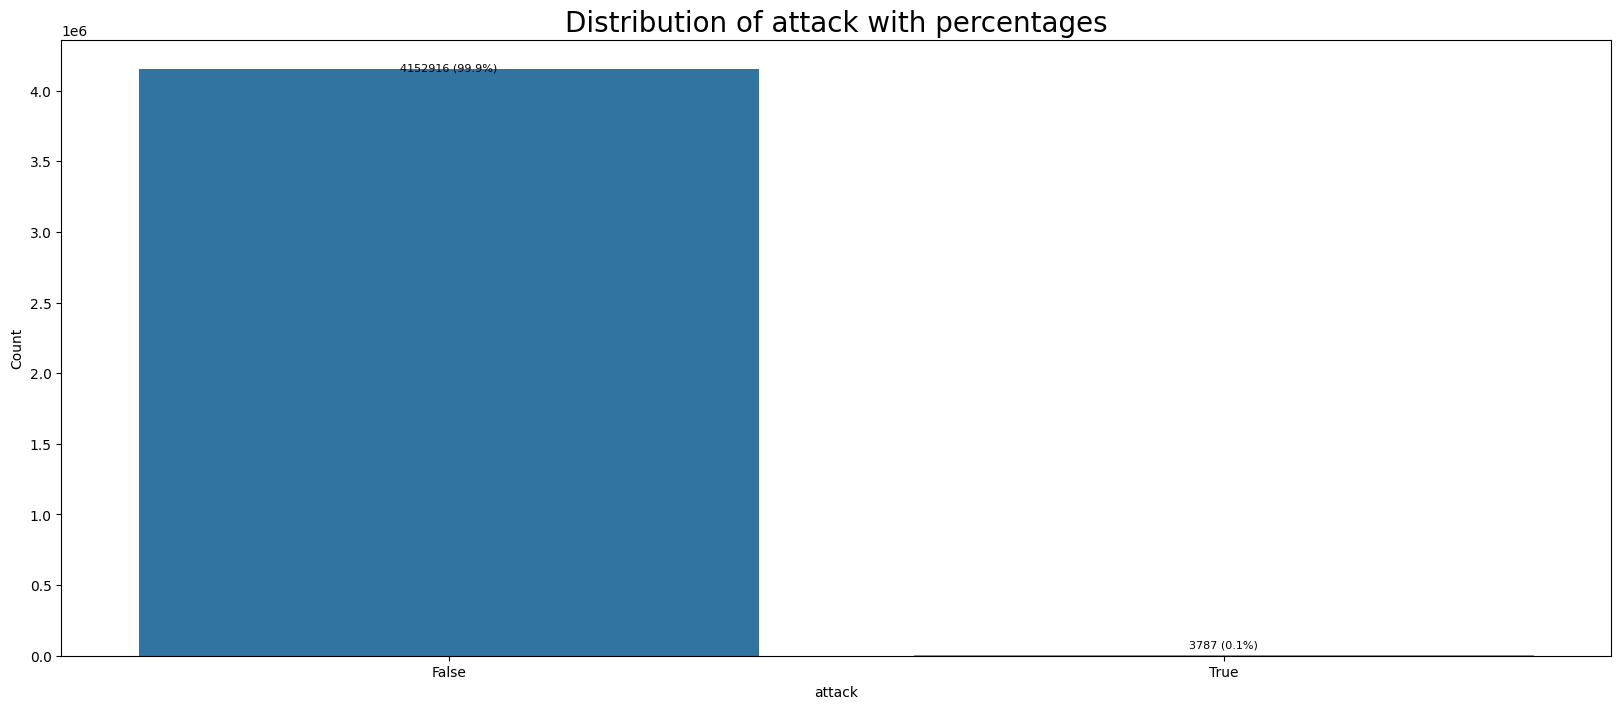

In [13]:
# Distribution of Attack with percentages
plot_distribution_with_percentages('attack')

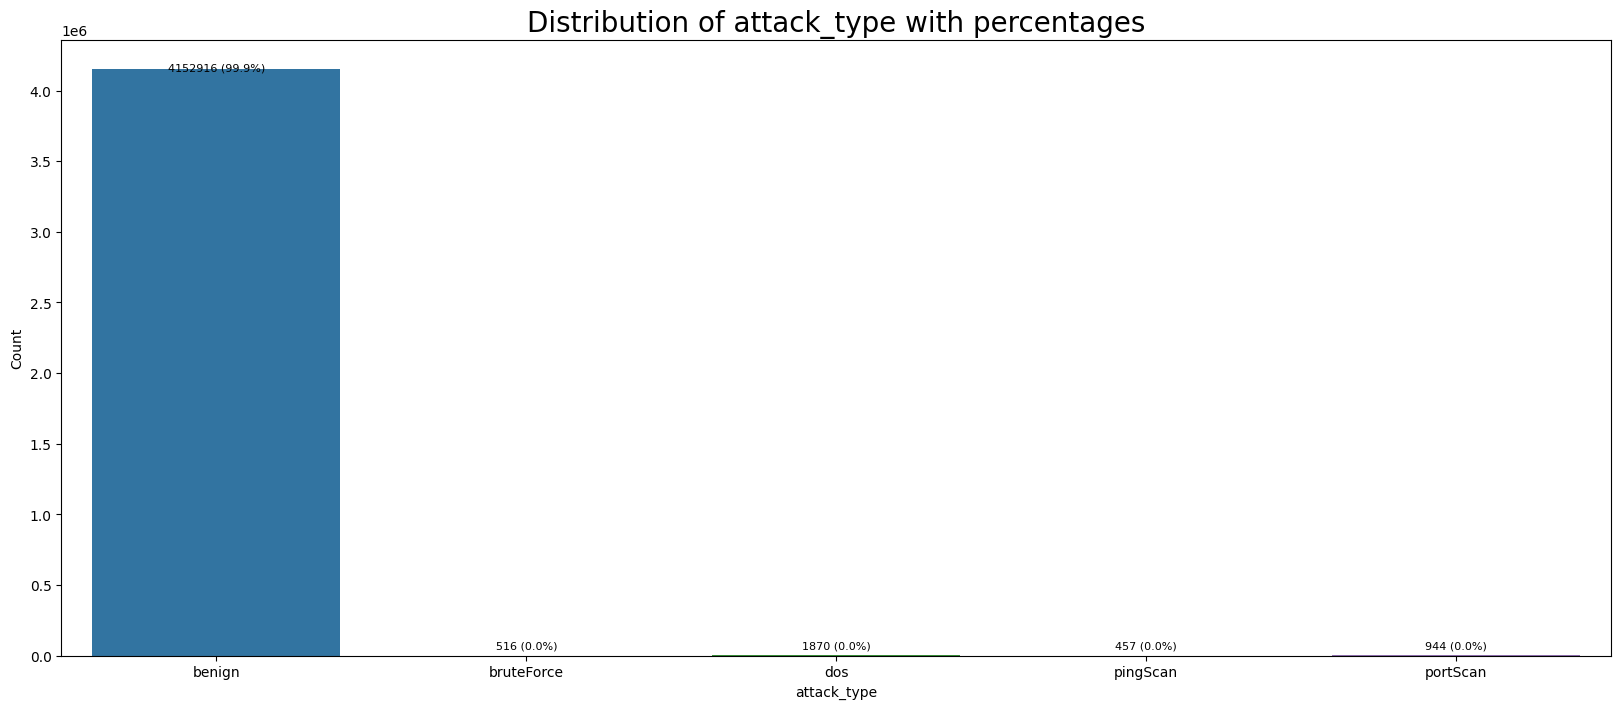

In [14]:
# Distribution of Attack Type with percentages
plot_distribution_with_percentages('attack_type')

### Covariate Analysis

In [15]:
# Compare column vs column
def hist_col_vs_col(col1, col2, top_n=10):
    # Get the top N categories by count in col2, to avoid a huge plot
    top_categories = df[col2].value_counts().head(top_n).index
    filtered_df = df[df[col2].isin(top_categories)]
    
    # Set dynamic title
    title_suffix = f" (top {top_n} for {col2})" if df[col2].nunique() > top_n else ""
    title = f'{col1} vs {col2}{title_suffix}'
    
    plt.figure(figsize=(20, 8))
    sns.countplot(x=col1, data=filtered_df, hue=col2, palette=sns.color_palette("dark", as_cmap=False, n_colors=filtered_df[col2].nunique()))
    plt.xticks(rotation=45)
    plt.title(title, fontsize=20)
    plt.legend(title=col2)
    plt.show()

Compare Attack vs Protocol

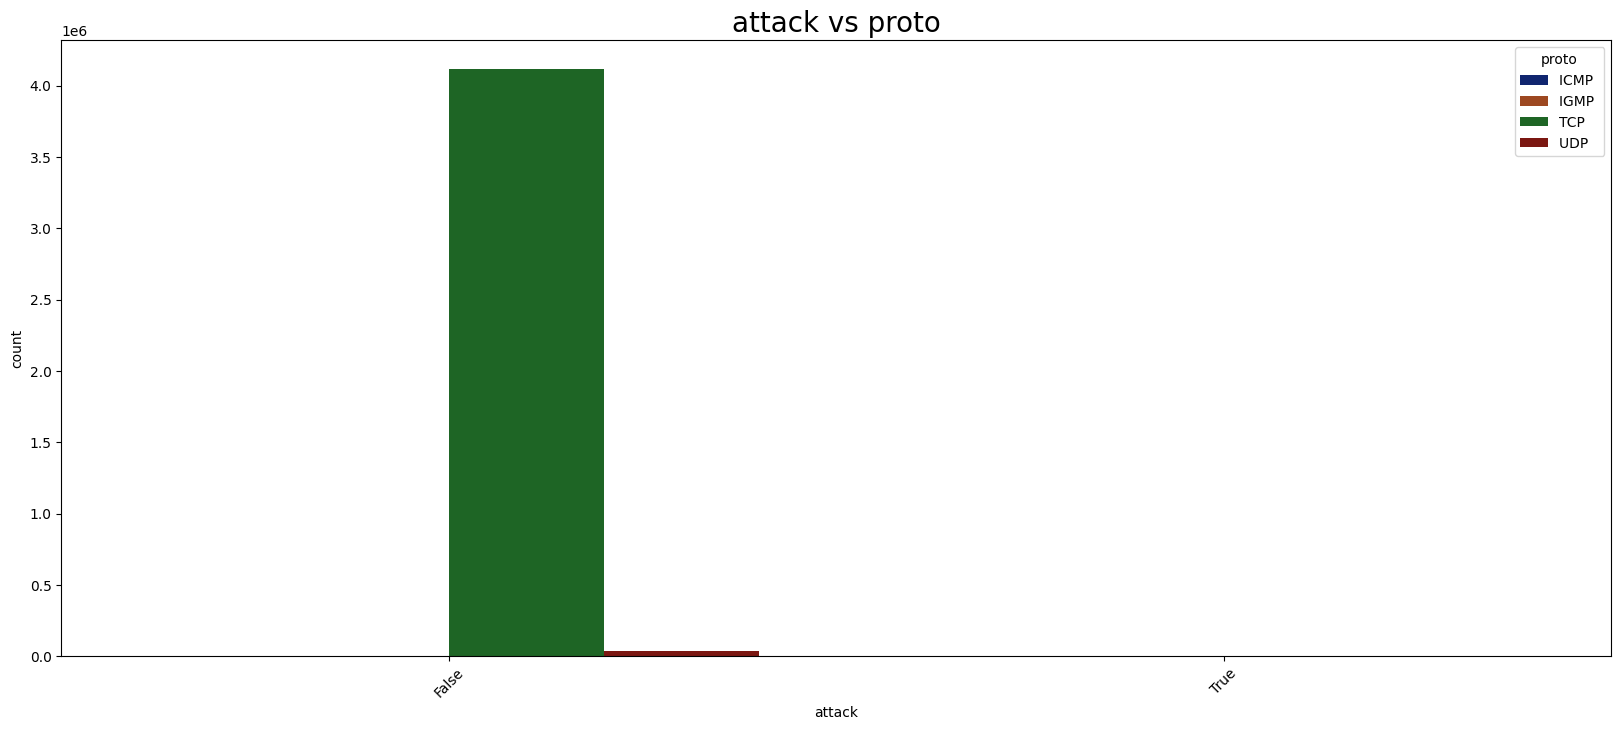

In [16]:
hist_col_vs_col('attack', 'proto')

Compare Attack Type vs Protocol

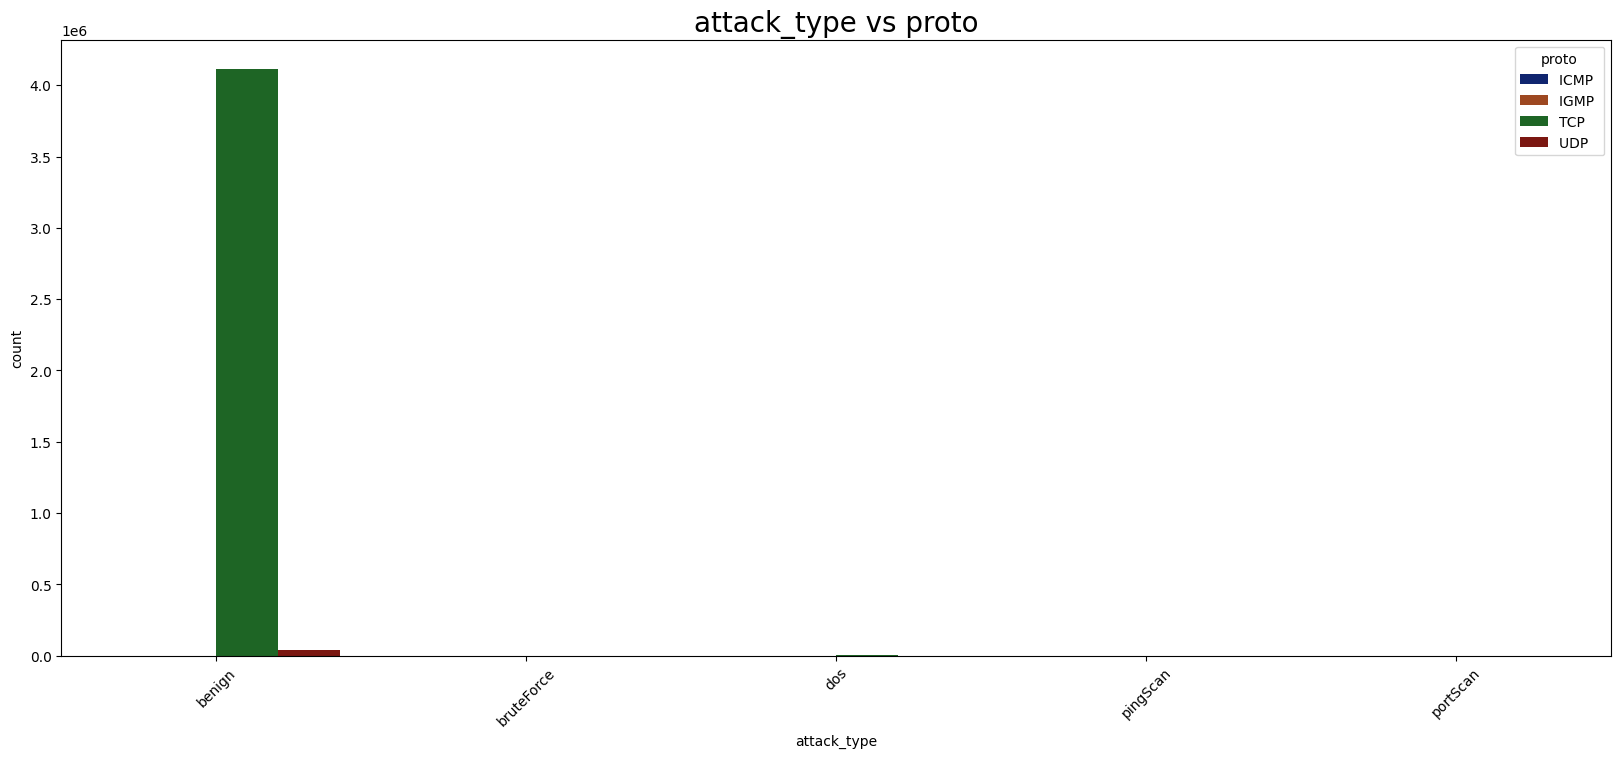

In [17]:
hist_col_vs_col('attack_type', 'proto')

Compare TCP SYN vs Attack

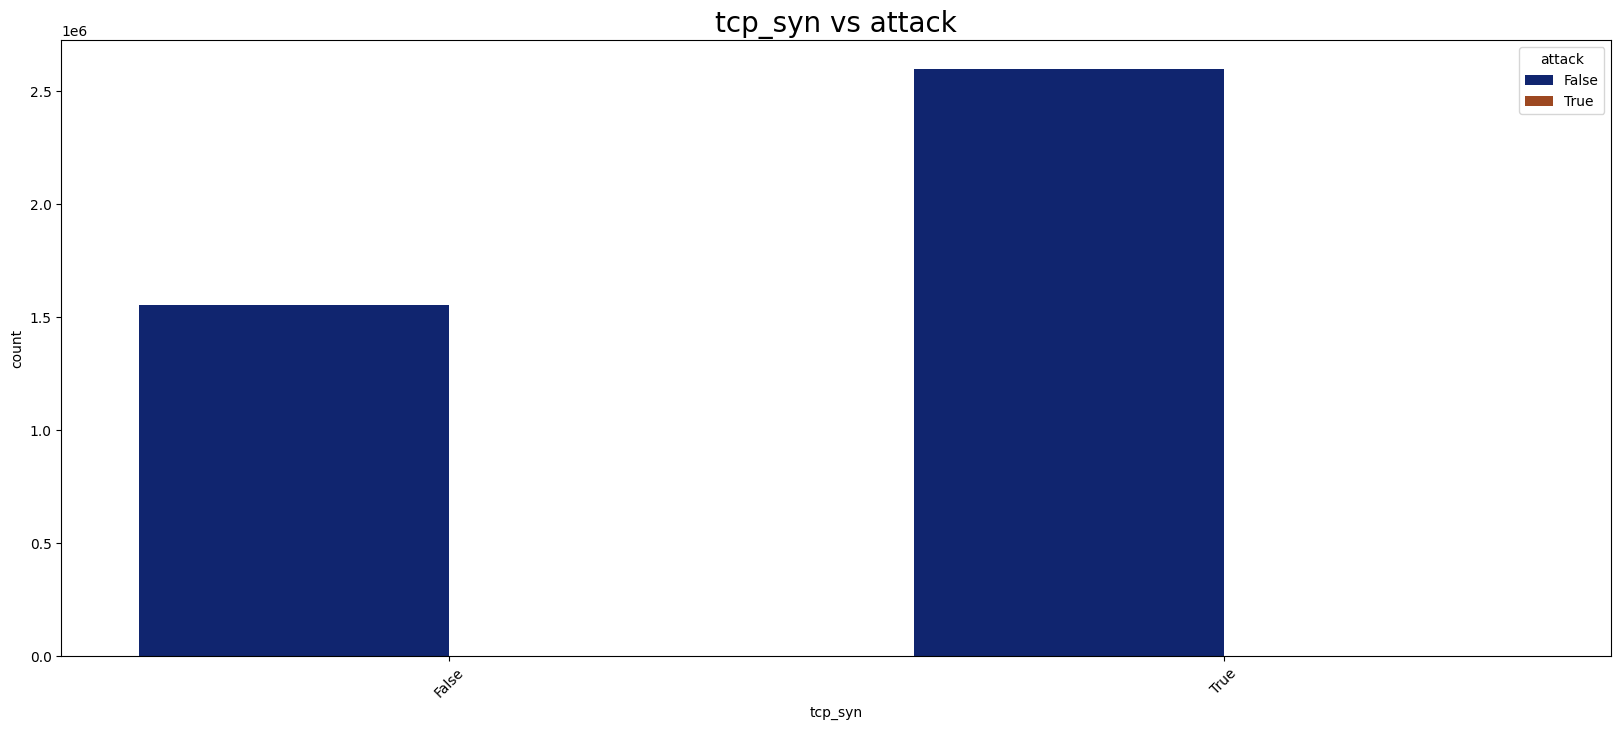

In [18]:
hist_col_vs_col('tcp_syn', 'attack')

Correlation matrix, useful for finding very correlated features

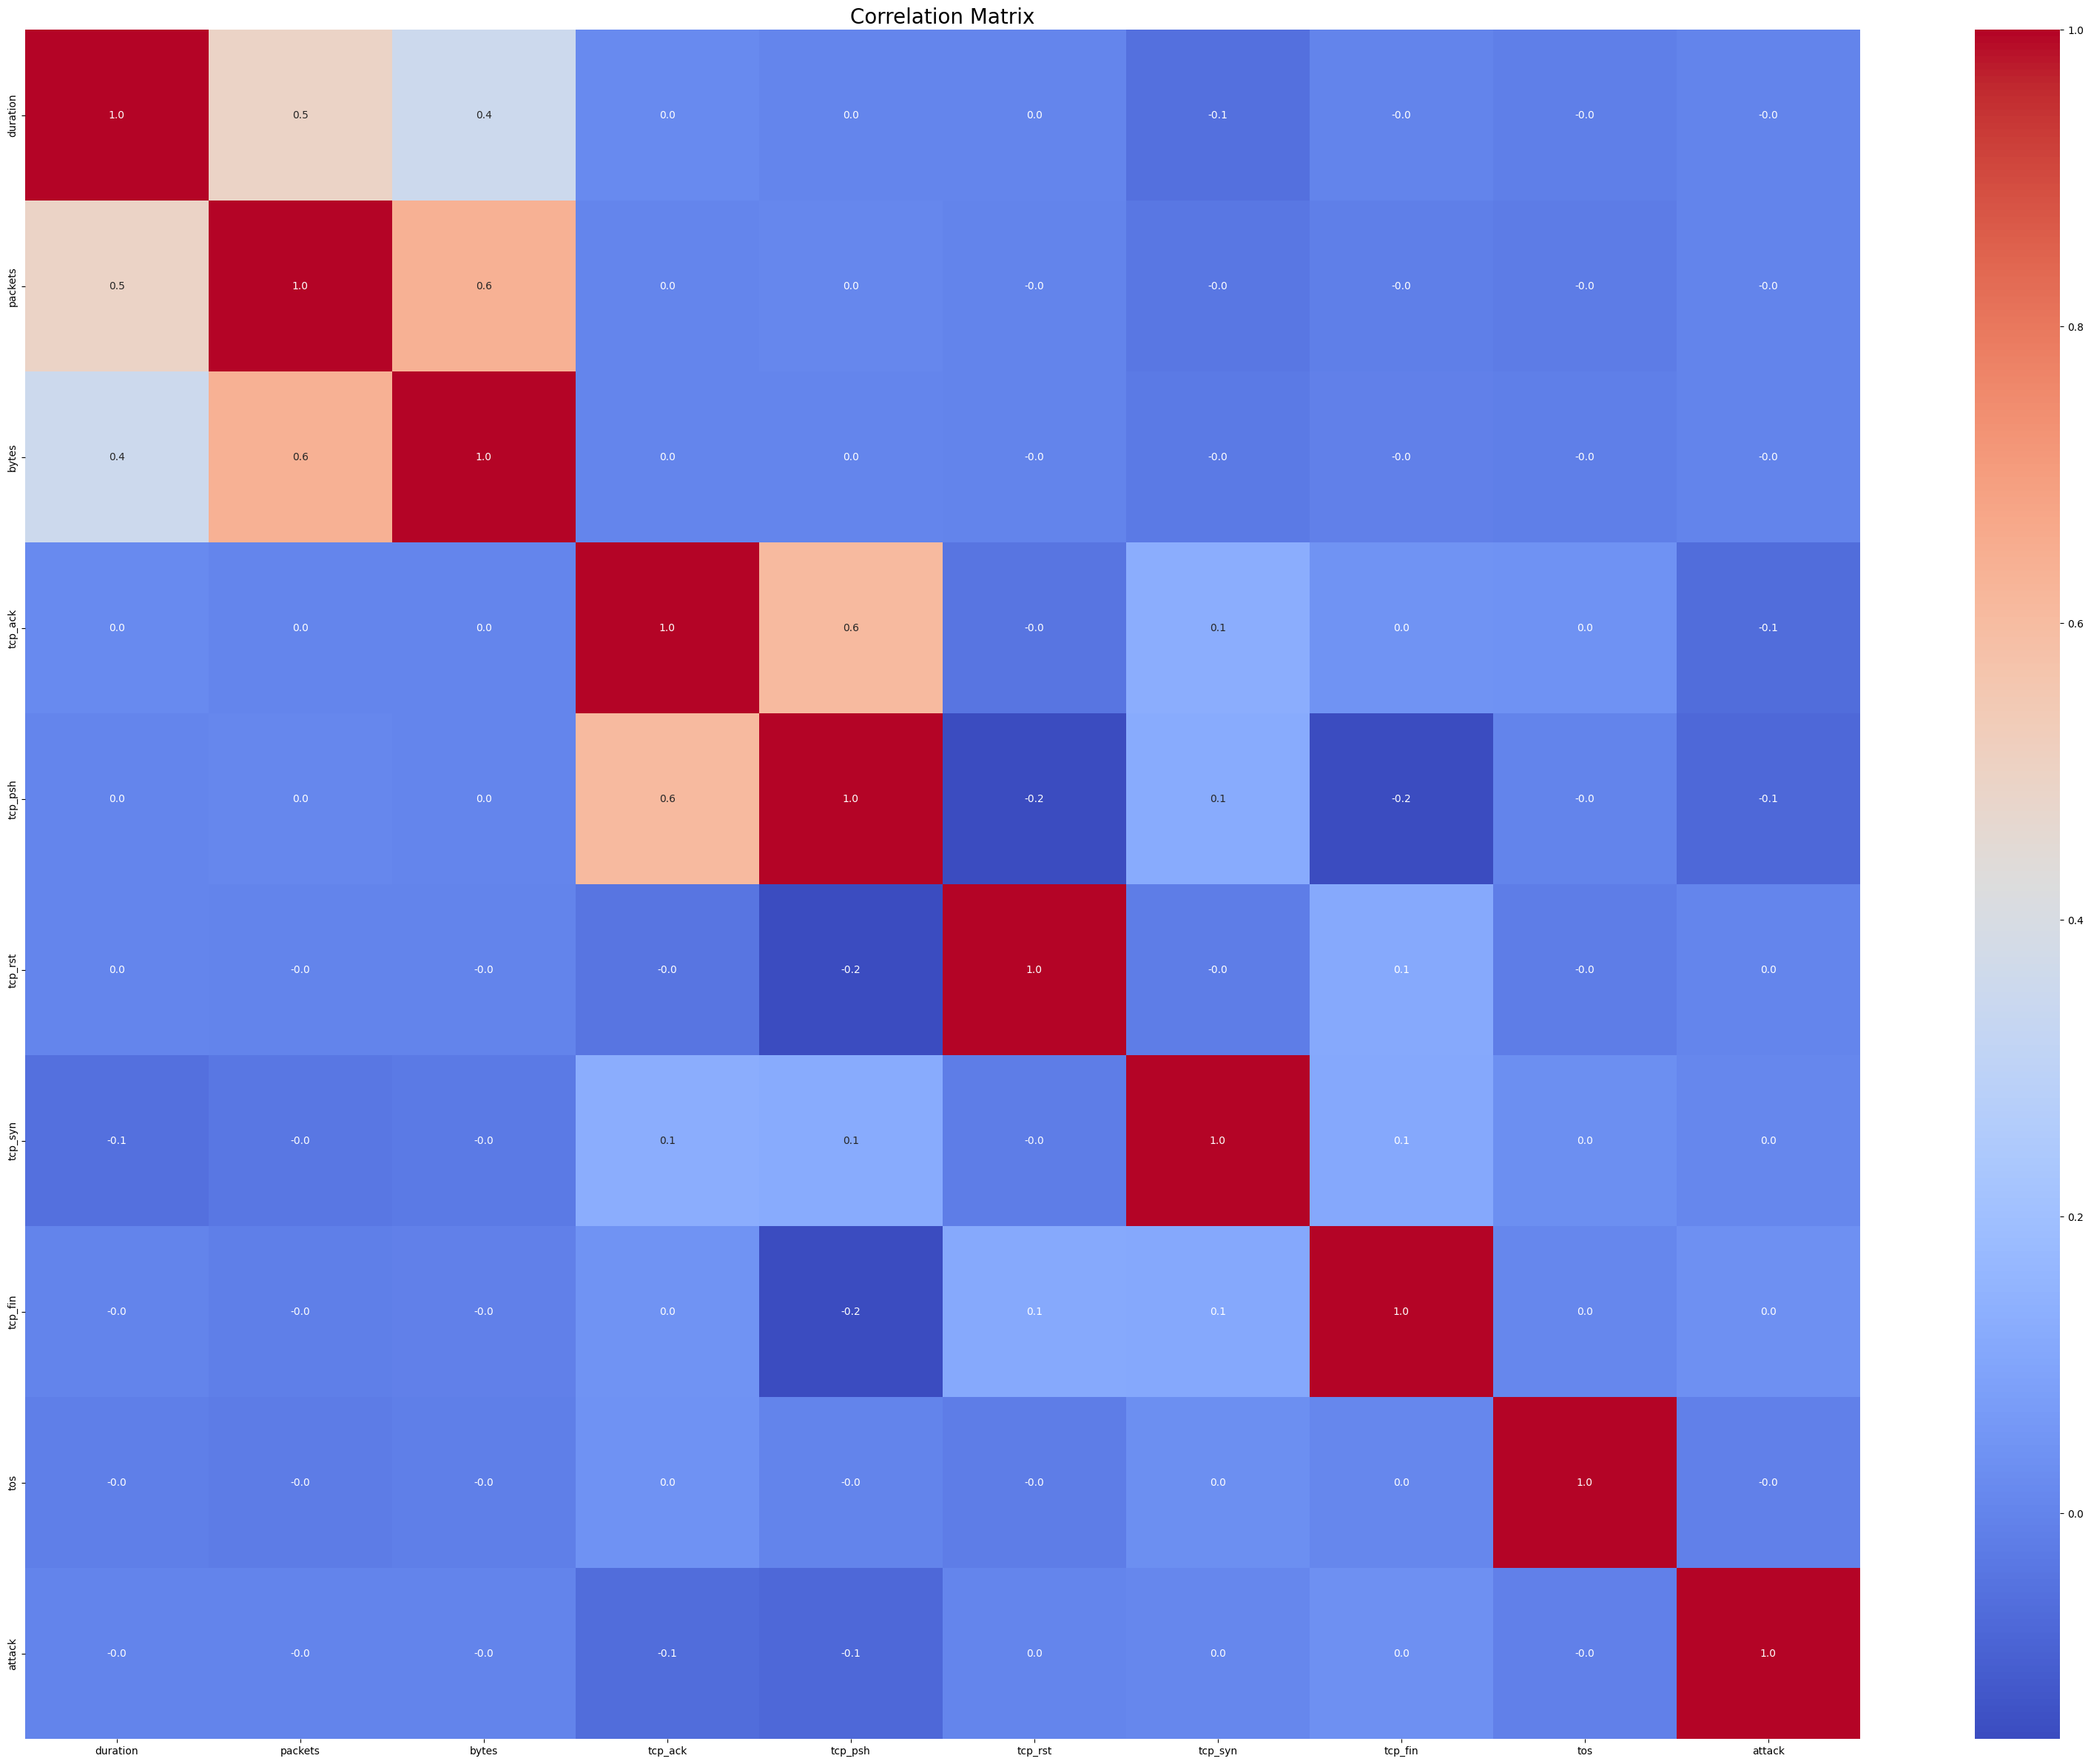

In [19]:
plt.figure(figsize=(40, 30))
correlation_matrix = df[df.select_dtypes(exclude=['object', 'category']).columns.tolist()].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", annot_kws={"size": 10})
plt.title("Correlation Matrix", fontsize=20)
plt.show()

No need to go further: the dataset is very very unbalanced (99.9% vs 0.1% !!!), **not recommended for use**.